# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [2]:
%matplotlib notebook
%pylab
import numpy as np
import scipy
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

Using matplotlib backend: nbAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [6]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=101)
    return corrected_lc

<IPython.core.display.Javascript object>


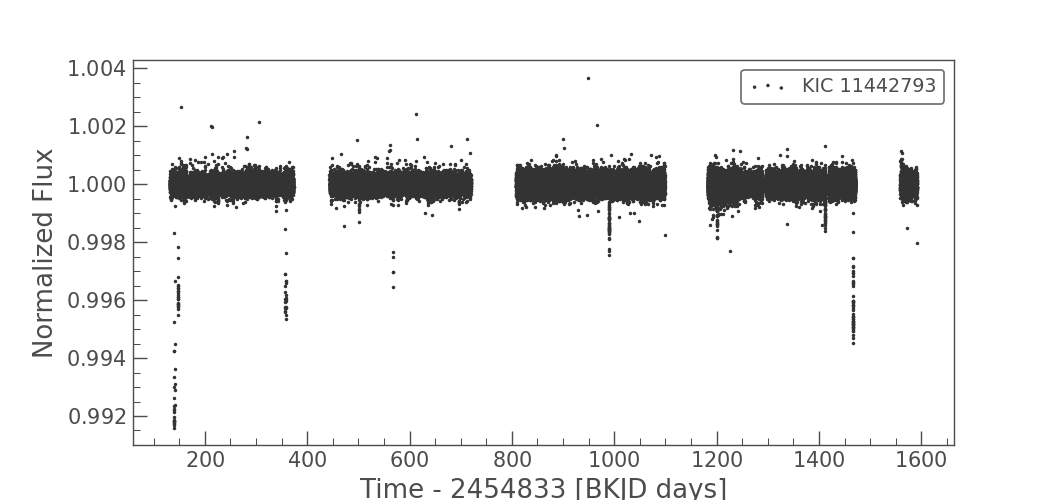

In [7]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.scatter();

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


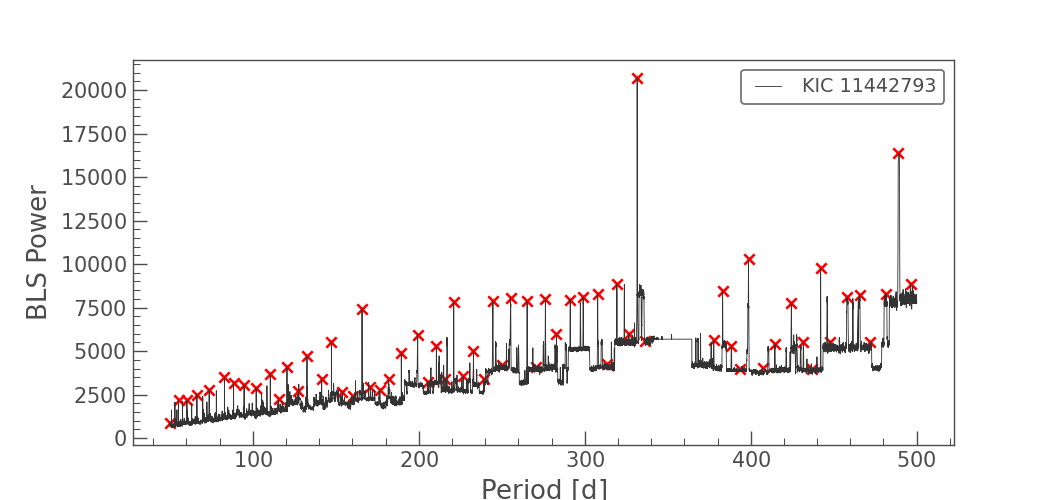

In [62]:
# YOUR CODE HERE
import astropy.units as u

periods = np.arange(50,500.01,0.01)

pg = clc.to_periodogram(method = 'bls', period = periods)

peaks,_ = scipy.signal.find_peaks(pg.power, distance = 500)
#periods = pg.period/u.day
print(type(periods))
mask = (periods[peaks]>370) | (periods[peaks]<340)
peak2 = peaks[mask]

pg.plot()
scatter(periods[peak2],pg.power[peak2],marker='x',color='r');

In [61]:
print(type(periods))

<class 'astropy.units.quantity.Quantity'>


# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [66]:
# YOUR CODE HERE
from astropy.table import Table
periods = pg.period[peak2]#pg.period[peak2]
power = pg.power[peak2]

sort = np.argsort(-1*power)
periodsort = periods[sort]
powersort = power[sort]
transits = pg.transit_time[sort]

tab = Table([periodsort,powersort,transits],\
           names = ['Period','Power','Transit'])
tab.sort('Power')

print(tab)

      Period             Power             Transit      
        d                                               
------------------ ------------------ ------------------
50.019999999999996  840.8345116613596 140.54264779216803
 55.26999999999895  2175.634353901371 140.54264779216803
 60.28999999999796  2176.245183098924 140.54264779216803
115.55999999998694 2235.3944372484525 140.54264779216803
160.53999999997802 2395.0373260064393 140.54264779216803
 66.31999999999675 2504.7717873284687 140.54264779216803
153.86999999997934 2661.7091238994053 140.54264779216803
               ...                ...                ...
 307.7999999999487  8293.724999192948 140.54264779216803
 383.0699999999337  8434.148097505618 140.54264779216803
 319.3599999999464  8855.210786992078 140.54264779216803
 496.3299999999112  8872.518499014725 140.54264779216803
 442.0999999999219  9769.379142672631 140.54264779216803
398.67999999993066 10280.183880628188 140.54264779216803
 488.9699999999127 16357.655761

# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [85]:
# YOUR CODE HERE
sort2 = np.argsort(-1*periods)
periodsort2 = np.array(periodsort[sort2]/u.day)
powersort2 = np.array(powersort[sort2]/u.day)
remove = []
for i in range(len(periodsort2)):
    for j in range(1,len(periodsort2)):
        if np.abs(periodsort2[i]-periodsort2[j]/2)<0.1 or np.abs(periodsort2[i]-periodsort2[j]/3)<0.1:
            remove.append(j)
            
for index in sorted(remove, reverse=True):
    periodsort2[index] = None
    powersort2[index] = None

mask = periodsort2 != None

goodper = np.nan_to_num(periodsort2[mask])
goodpow = np.nan_to_num(powersort2[mask])

    
mask1 = (goodper > 0.) & (goodper <= 100.)
mask2 = (goodper > 100.) & (goodper <= 200.)
mask3 = (goodper > 200.) & (goodper <= 300.)
mask4 = (goodper > 300.) & (goodper <= 400.)

masklist = [mask1,mask2,mask3,mask4]
powerpeaks = []
periodpeaks = []
for i in range(4):
    powerpeaks.append(np.max(powersort2[masklist[i]]))
    periodpeaks.append(goodper[np.where(powersort2==powerpeaks[i])])
    
print(periodpeaks)

[array([82.9]), array([199.34]), array([299.02]), array([319.36])]


# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

In [99]:
# YOUR CODE HERE
def per_refiner(peakper):
    period = np.arange(peakper-5, peakper+5, 0.001)
    pg2 = clc.to_periodogram(method='bls', period=period)

    power = pg2.power
    peaks,_ = scipy.signal.find_peaks(power, prominence = 2000)
    newper = period[peaks][np.argmax(power[peaks])]
    transit = pg2.transit_time[peaks][np.argmax(power[peaks])]
    return (newper,transit)

In [100]:
refperpeaks = []
transits = []
for period in periodpeaks:
    refperpeaks.append(per_refiner(period)[0])
    transits.append(per_refiner(period)[1])
print(refperpeaks)

[82.89700000001731, 199.3219999999941, 299.04399999983167, 319.3549999998283]


# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

<IPython.core.display.Javascript object>


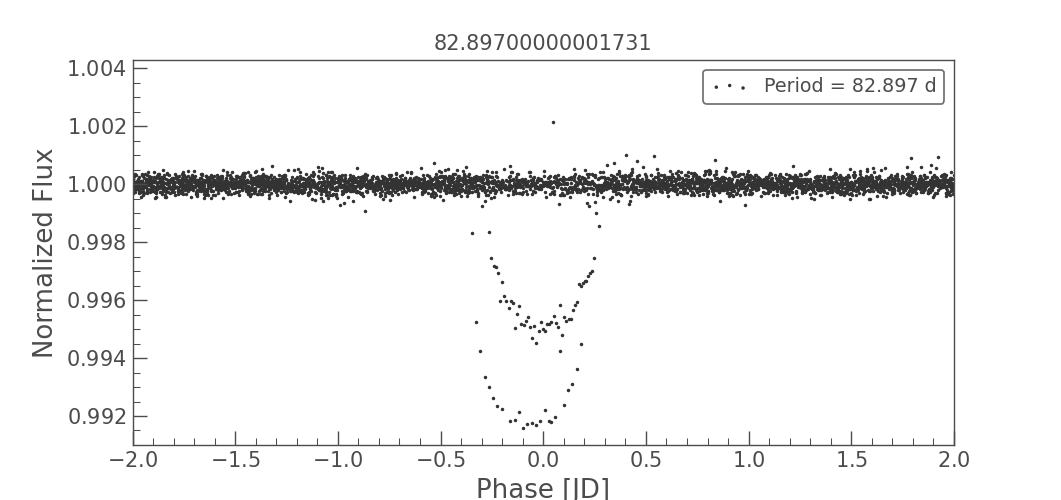

<IPython.core.display.Javascript object>


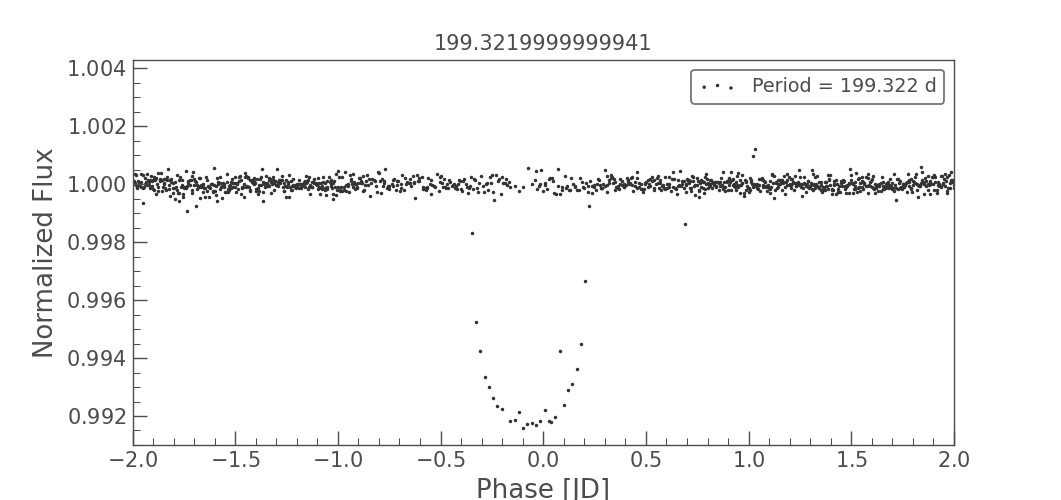

<IPython.core.display.Javascript object>


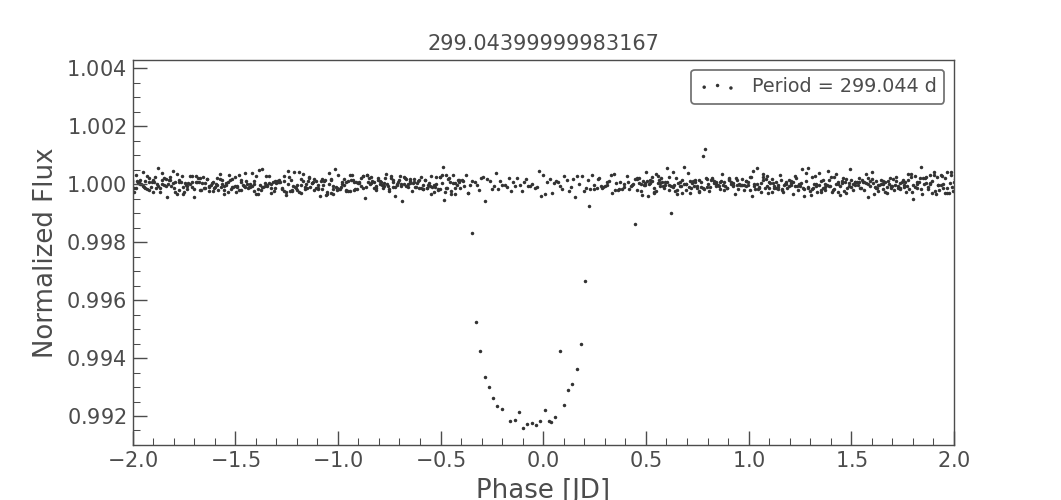

<IPython.core.display.Javascript object>


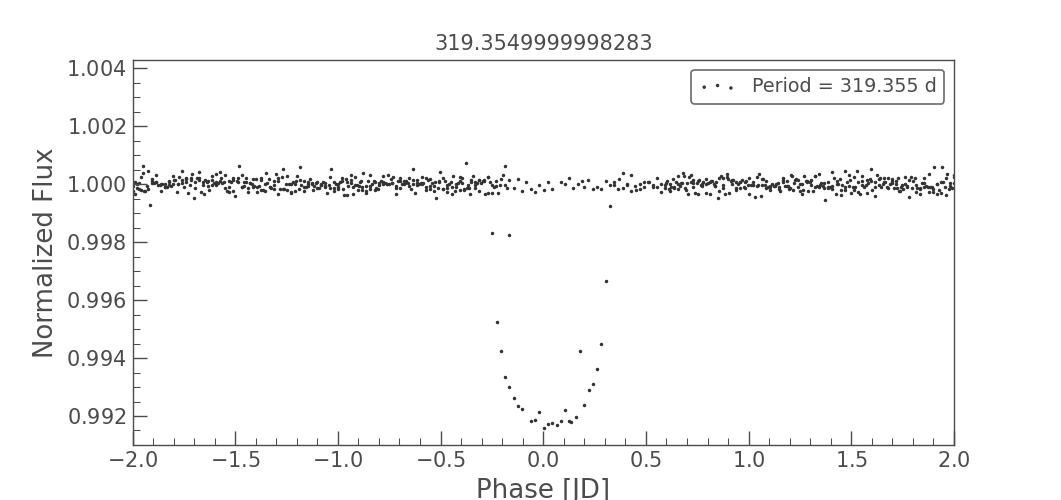

In [102]:
# YOUR CODE HERE


for i in range(len(refperpeaks)):
    ax = clc.fold(period = refperpeaks[i],epoch_time = transits[i]).scatter(label=f'Period = {refperpeaks[i]:.3f} d');
    ax.set_xlim(-2, 2)
    ax.set_title(refperpeaks[i])